In [1]:
!pip install geoopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 90 kB 7.2 MB/s 


In [3]:
import torch
# import scipy.linalg
import sys

import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.distributions as D

from tqdm.auto import trange
from geoopt import linalg

# sys.path.append("./lib")
from swspd import *
from utils_spd import busemann_spd
# from logm import logm

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

### Busemann

In [5]:
theta = torch.randn(1000, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [8]:
M = torch.eye(2, device=device)
M = M.reshape((1, 2, 2))
M = M.repeat(10, 1, 1)

## Compute logM in advance since we cannot batch it
# log_M = torch.zeros(M.shape, device=device)
# for k in range(len(log_M)):
#     log_M[k] = logm(M[k])
log_M = linalg.sym_logm(M)

In [9]:
b = busemann_spd(log_M, dA)

In [10]:
print(log_M.shape, dA.shape)
print(b.shape)

torch.Size([10, 2, 2]) torch.Size([1000, 2, 2])
torch.Size([10, 1000])


In [11]:
b

tensor([[-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        ...,
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.],
        [-0., -0., -0.,  ..., -0., -0., -0.]], device='cuda:0')

In [12]:
ts = torch.linspace(-10,10,200).to(device)
ts = ts.reshape(ts.shape[0],1,1)
ts = ts.repeat(1,2,2)

In [13]:
theta = torch.randn(3, 2).to(device)
theta = theta/torch.sqrt(torch.sum(theta**2, axis=-1))[:,None]
A = theta[:,None] * torch.eye(theta.shape[-1], device=device)
    
## Preprocessing to compute the matrix product using a simple product
diagA = torch.diagonal(A, dim1=-2, dim2=-1)
dA = diagA.unsqueeze(-1)
dA = dA.repeat(1,1,2)

In [14]:
M = torch.linalg.matrix_exp(ts[:,None]*A[None])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: An output with one or more elements was resized since it had shape [6, 2, 2], which does not match the required output shape [1, 6, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: An output with one or more elements was resized since it had shape [32, 2, 2], which does not match the required output shape [1, 32, 2, 2]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Tri

In [15]:
print(ts.shape, A.shape, M.shape)

torch.Size([200, 2, 2]) torch.Size([3, 2, 2]) torch.Size([200, 3, 2, 2])


In [16]:
L = np.zeros((ts.shape[0],M.shape[1],A.shape[0]))

for i, t in enumerate(ts):
    # log_M = torch.zeros(M[i].shape, device=device)
    # for k in range(len(log_M)):
    #     log_M[k] = logm(M[i][k])
    
    log_M = linalg.sym_logm(M[i])
    b = busemann_spd(log_M, dA)
    L[i] = b.detach().cpu()

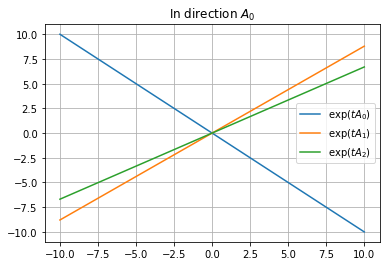

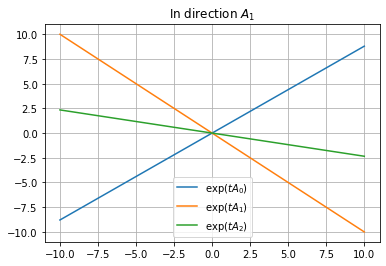

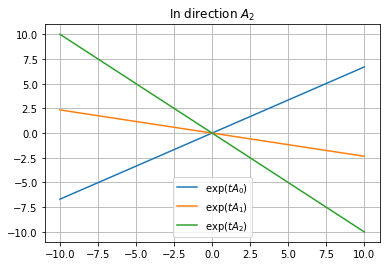

In [17]:
for i in range(A.shape[0]):
    for k in range(3):
        plt.plot(ts[:,0,0].cpu(), L[:,k,i], label=r"$\exp(t A_"+str(k)+r")$")
    plt.title(r"In direction $A_"+str(i)+r"$")
    plt.legend()
    plt.grid(True)
    plt.show()

### Sliced-Wasserstein

In [18]:
X0 = M[:,0]
X1 = M[:,1]

In [19]:
sw = sliced_wasserstein_spd(X0, X1, 500, device=device).item()
sw

3.1841461658477783

In [20]:
X0 = M[:,0]
X1 = M[:,0]

sw = sliced_wasserstein_spd(X0, X1, 500, device=device).item()
sw

0.0

#### Test Wishart Distribution

In [33]:
m0 = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), torch.eye(2, dtype=torch.float64, device=device))

In [34]:
B0 = m0.sample((100,))[:,0]

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


In [35]:
B0.shape

torch.Size([100, 2, 2])

In [36]:
sw = sliced_wasserstein_spd(X0, B0, 500, device=device).item()
sw

7.876422655950246

In [38]:
ntry = 20
nsamples = 500
nprojs = 500

ts = torch.linspace(0.1,10,200)
L = np.zeros((ntry, len(ts)))

bar = trange(ntry)
for k in bar:
    # pbar = trange(len(ts))
    pbar = range(len(ts))
    for i in pbar:
        t = ts[i]
        mt = D.Wishart(torch.tensor([2], dtype=torch.float64).to(device), t*torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((nsamples,))[:,0]
        Bt = mt.sample((nsamples,))[:,0]

        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L[k, i] = sw

  0%|          | 0/20 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


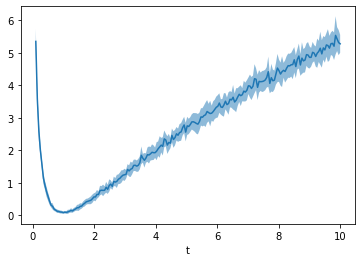

In [39]:
m = np.mean(L, axis=0)
s = np.std(L, axis=0)

plt.plot(ts, m)
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t")
plt.show()

In [41]:
mt = D.Wishart(torch.tensor([2], dtype=torch.float64, device=device), torch.eye(2, dtype=torch.float64, device=device))
B0 = m0.sample((10000,))[:,0]
Bt = mt.sample((10000,))[:,0]

sw = sliced_wasserstein_spd(B0, Bt, 500, device=device).item()
sw

/usr/local/lib/python3.7/dist-packages/torch/distributions/wishart.py:247: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


0.00840235133729288

In [45]:
ntry = 20
nsamples = 500
nprojs = 500

ts = torch.linspace(1.1,10,200)
L = np.zeros((ntry, len(ts)))

bar = trange(ntry)
for k in bar:
    pbar = range(len(ts))

    for i in pbar:
        t = ts[i]
        mt = D.Wishart(t*torch.tensor([1], dtype=torch.float64, device=device), torch.eye(2, dtype=torch.float64, device=device))
        B0 = m0.sample((nsamples,))[:,0]
        Bt = mt.sample((nsamples,))[:,0]
        
        sw = sliced_wasserstein_spd(B0, Bt, nprojs, device=device).item()
        L[k, i] = sw
    

  0%|          | 0/20 [00:00<?, ?it/s]

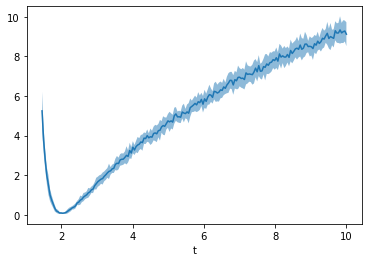

In [46]:
m = np.mean(L, axis=0)
s = np.std(L, axis=0)

plt.plot(ts, m)
plt.fill_between(ts, m-s, m+s, alpha=0.5)
plt.xlabel("t")
plt.show()